In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

In [2]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
import pickle
import pandas as pd
import os
import random
import seaborn as sns

from tqdm import tqdm
from src.data.loaders import get_loader
from joblib import Parallel, delayed
from functools import partial

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

2024-12-20 17:39:43.644037: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-20 17:39:43.644081: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-20 17:39:43.644107: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 17:39:43.652595: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## MACHO stats

In [3]:
def get_stat(path, on='mag', window=100):
    observations = pd.read_parquet(path)
    observations = observations[(observations['errmag']>0) & (observations['errmag']<1)]
    
    if on == 'mjd':
        observations = observations.groupby('newID').diff().dropna()
        
    observations = observations.sort_values(on)
    observations = observations[on].rolling(window=window, step=window).mean()
    return observations.dropna().tolist()

def calculate_stat(root, on='mag', window=1000, njobs=4):
    lc_paths = os.listdir(root)
    preloaded = partial(get_stat, on=on, window=window)
    var = Parallel(n_jobs=njobs, backend='threading')
    results = var(delayed(preloaded)(os.path.join(root, p)) for p in lc_paths )
    flattened = [item for sublist in results for item in sublist]
    return flattened

In [4]:
%%time
root = './data/raw_parquet/macho/light_curves/'
macho_mjd = calculate_stat(root, on='mjd', njobs=16)
macho_mjd = np.array(macho_mjd)[np.array(macho_mjd)>0]

macho_mag = calculate_stat(root, on='mag', njobs=16)

CPU times: user 15min 43s, sys: 10min 1s, total: 25min 44s
Wall time: 1min 46s


In [5]:
%%time
root = './data/raw_parquet/alcock/light_curves/'
other_mjd = calculate_stat(root, on='mjd', njobs=16)
other_mjd = np.array(other_mjd)[np.array(other_mjd)>0]

other_mag = calculate_stat(root, on='mag', njobs=16)

CPU times: user 5.91 s, sys: 2.23 s, total: 8.14 s
Wall time: 5.55 s


In [6]:
%%time
root = './data/raw_parquet/atlas/light_curves/'
atlas_mjd = calculate_stat(root, on='mjd', njobs=16)
atlas_mjd = np.array(atlas_mjd)[np.array(atlas_mjd)>0]

atlas_mag = calculate_stat(root, on='mag', njobs=16)

CPU times: user 5min 10s, sys: 1min 16s, total: 6min 26s
Wall time: 23.8 s


In [16]:
np.median(atlas_mjd)

0.015542489999359532

In [9]:
# with open('./data/shared/records/bigmacho/bigmacho_magnitudes.pickle', 'rb') as handle:
#     bighmacho_mag = pickle.load(handle)

# indices = np.arange(len(bighmacho_mag))
# np.random.shuffle(indices)
# indices = indices[:len(macho_mag)*2]
# bighmacho_mag = np.array(bighmacho_mag)[indices]
# len(bighmacho_mag)

In [10]:
def reduce_vector(vector, n=100):
    indices = np.arange(len(vector))
    np.random.shuffle(indices)
    vector = np.array(vector)[:100]
    return vector

2024-12-20 18:55:11,946 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-20 18:55:11,950 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
<timed exec>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


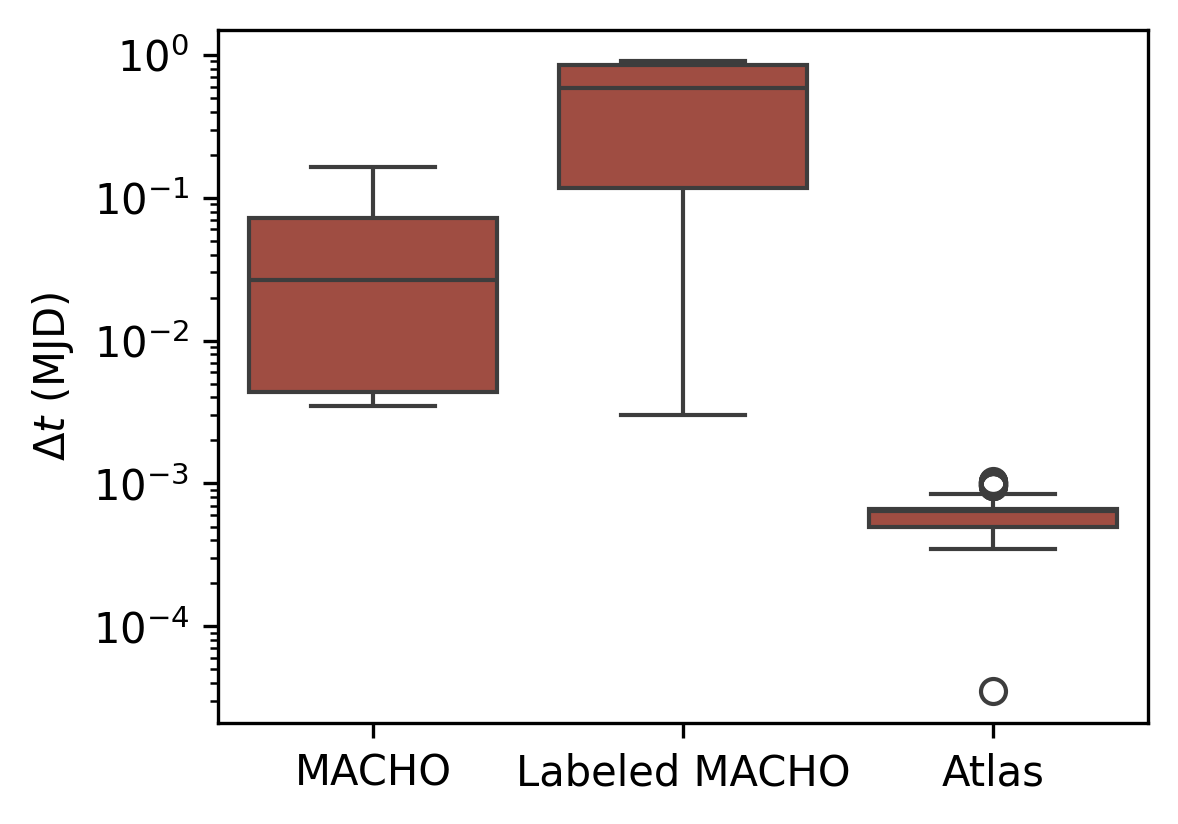

CPU times: user 500 ms, sys: 434 ms, total: 934 ms
Wall time: 410 ms


In [26]:
%%time
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4,3))
sns.boxplot(data=[reduce_vector(macho_mjd), 
                  reduce_vector(other_mjd), 
                  reduce_vector(atlas_mjd)], ax=ax, color='#AE4132')

ax.set_yscale('log')
ax.set_ylabel(r'$\Delta t$ (MJD)')
ax.set_xticklabels(['MACHO', 'Labeled MACHO', 'Atlas'])

fig.savefig('./presentation/figures/mjd_datasets.pdf', 
            format='pdf', 
            bbox_inches='tight')
plt.show()

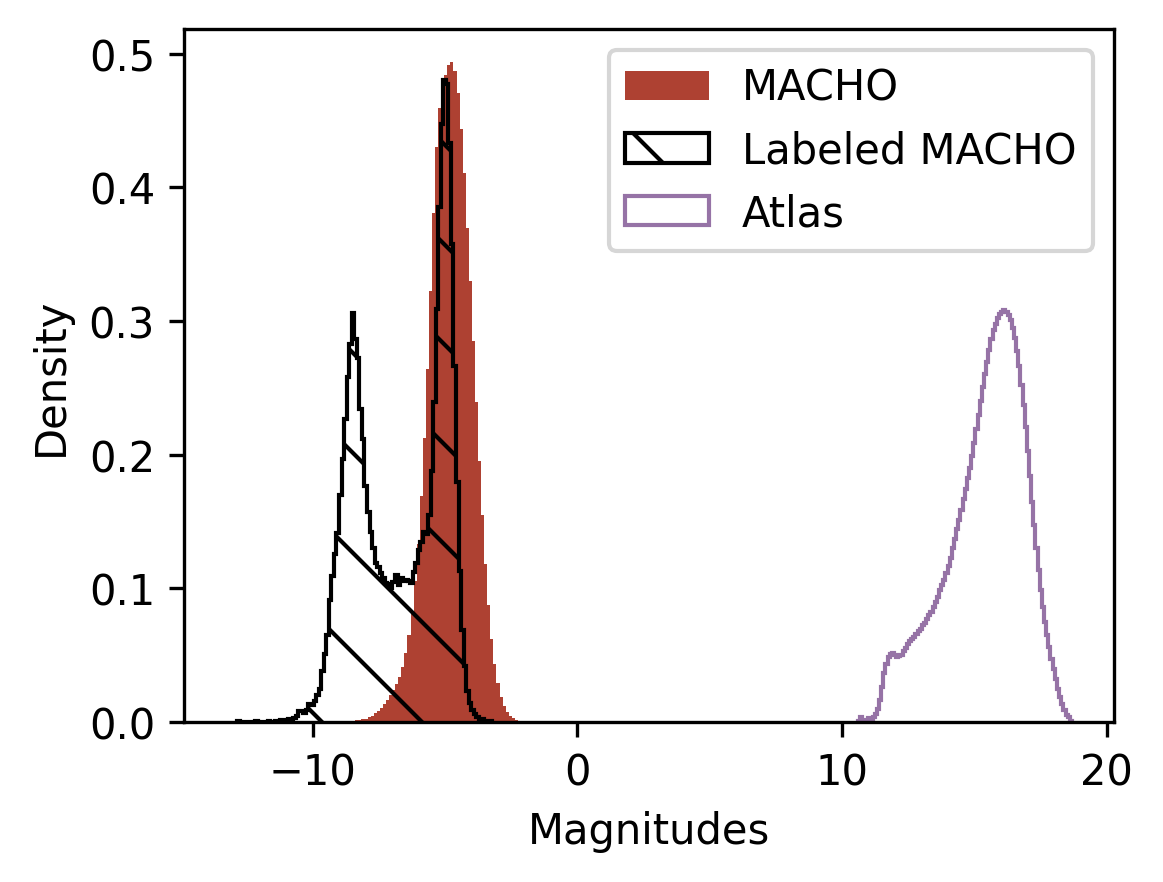

CPU times: user 3.82 s, sys: 516 ms, total: 4.34 s
Wall time: 3.88 s


In [24]:
%%time
plt.figure(figsize=(4, 3), dpi=300)
h1 = plt.hist(macho_mag, bins=100,  density=True, label='MACHO', facecolor='#AE4132')
h2 = plt.hist(other_mag, bins=100,  density=True, label='Labeled MACHO', facecolor='k', edgecolor='k', histtype='step', hatch='\\')
h3 = plt.hist(atlas_mag, bins=100,  density=True, label='Atlas', histtype='step', color='#9673A6')
plt.legend()
plt.xlabel('Magnitudes')
plt.ylabel('Density')
# plt.yscale('log')
plt.savefig('./presentation/figures/magnitude_datasets.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
scan2 = pl.scan_parquet('./data/raw_parquet/alcock/light_curves/*.parquet')